# Principles of a bootstrap aggregation of stable clusters
This tutorial illustrates the basic principles behind the "Bootstrap Aggregation of Stable Clusters (BASC)" algorithm for fMRI time series, using simulations and real data. 

  * **Time for completion**: this tutorial will take 5-10 minutes to complete. 
  * **Dependencies**: 
    - jupyter>=1.0.0
    - matplotlib>=3.1.1
    - nilearn>=0.5.2
    - numpy>=1.17.0
    - scikit-learn>=0.21.2
    - scipy>=1.3.0

In [1]:
%matplotlib inline
import numpy as np
from scipy import corrcoef
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import matplotlib.pyplot as plt

from sklearn import cluster, metrics

from nilearn import datasets
from nilearn import image
from nilearn.input_data import NiftiLabelsMasker
from nilearn import plotting

/home/pbellec/env/jupyter_ds/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


The only part of the tutorial that can be slow is to download the fMRI data we will use to try the algorithm. Executing the following cell will cache the data on your computer.

In [2]:
abide_dataset = datasets.fetch_abide_pcp(n_subjects=1) # A single subject from the ABIDE preprocessed project
multiscale = datasets.fetch_atlas_basc_multiscale_2015() # A precomputed brain atlas

/home/pbellec/env/jupyter_ds/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


We'll also set the seed of the random number generator, for reproducibility:

In [3]:
np.random.seed(0)

# Simulations
## Simulate time series with a known cluster structure
Let's start with a function which simulates time series. The following function deals with the simulation of the time series, and uses a mixture model of Gaussians. The simulations just consist of random gaussian noise. We add a single (random) single signal to all regions within a cluster. All clusters are set to have the same size. 

In [4]:
def simu_tseries(n_time, n_roi, n_clusters, alpha):
    """ Simulate time series for multiple ROIs.
        Returns: y (the time series), gt (ground truth partition)
    """
    noise = np.random.normal(size=[n_roi , n_time]) # Some Gaussian random noise
    gt = np.zeros(shape=[n_roi,1]) # Ground truth clusters
    y = np.zeros(noise.shape) # The final time series
    ind = np.linspace(0,n_roi,n_clusters+1,dtype="int") # The indices for each cluster
    for cc in range(0, n_clusters): # for each cluster
        cluster = range(ind[cc], ind[cc + 1]) # regions for that particular cluster
        sig = np.random.normal(size=[1, n_time]) # a single signal 
        y[cluster, :] = noise[cluster, :] + alpha * np.repeat(sig, ind[cc + 1] - ind[cc],0) # y = noise + a * signal
        gt[cluster] = cc # Adding the label for cluster in ground truth
    return y, gt

The simulation uses the following parameters: a small number of time points (300), a small number of regions (150) and 5 clusters of equal size (that would be 30 regions per cluster). The `alpha` parameter is set high for now, so we can clearly see the clusters.

In [5]:
y, gt = simu_tseries(n_time=100, n_roi=150, n_clusters=5, alpha=0.7)

The array Let's visualize the matrix of correlation coefficients between time series, across all pairs of regions.

(150, 100)

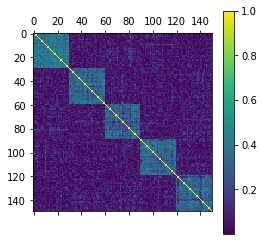

In [6]:
R = corrcoef(y)
plt.matshow(np.abs(R))
plt.colorbar()
y.shape

Note that `y` is a numpy array with 150 rows (regions) and 100 columns (time points). We can see clear diagonal squares. For pairs of regions within a square (cluster), the correlation is about 0.5. By contrast, off-diagonal coefficients have close to zero correlations. The five squares are the five clusters of interest. But in case we have too much noise to see them clearly, the "ground truth" of the true cluster structure used in the simulation is saved in the vector `gt`:

(150, 1)

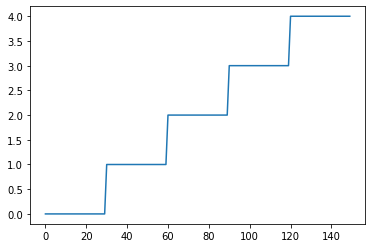

In [7]:
plt.plot(gt)
gt.shape

`gt` is a vector where each entry is a region, and the value associated with a region is an integer value coding for the number of the cluster (starting from 0, and following an arbitrary order).

## k-means clustering
Let's try to recover the clusters with a simple k-means clustering. We'll use k-means as a black box here. It takes `y` as an input, and tries to guess `gt`. We need to specify the number of clusters though, but here we know exactly what it is (`n_cluster = 5`), and we're not going to try to guess it. Note that k-means is one of the oldest, standard clustering algorithms, and you can learn more on its inner workings by following this [tutorial](https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html).

In [8]:
cent, part, inert  = cluster.k_means(y, n_clusters=5, init="random", max_iter=30)

The output `part` is the estimation of `gt` through the k-means algorithm. Let's see what it looks like.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f62fccc2b70>,
 Text(0.5, 1.0, 'gt'))

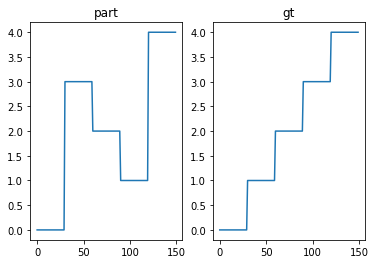

In [9]:
plt.subplot(1,2,1), plt.plot(part), plt.title('part')
plt.subplot(1,2,2), plt.plot(gt), plt.title('gt')

This is looking good! Perfect, in fact. Except the number associated with each cluster appears to be random. But it doesn't matter, because these cluster labels are arbitrary anyway. How can we quantify how good `part` is, without getting mixed up by the cluster labels? 

# A detour: adjacency matrix and adjusted Rand
For measuring the similarity of two cluster solutions, it is useful to represent the clusters as **adjacency matrices**. This representation is also key for the particular BASC flavor we are going to implement, so it's worth taking this little detour. The following function takes a cluster like `gt` and builds a matrix region x region. If two regions are in the same cluster, the value in the matrix is 1. Otherwise it is zero. That's called the adjacency matrix representation of the clustering. 

In [10]:
def part2adj(part):
    """ Convert a clustering vector, with integer labels, into an adjancency matrix
    """
    part = np.reshape(part, [part.shape[0], 1])
    adj = np.repeat(part, part.shape[0], 1) == np.repeat(part.transpose(), part.shape[0], 0)
    return adj.astype(int)

Now let's look at the two adjacency matrices side by side (estimated vs ground truth): 

(<matplotlib.axes._subplots.AxesSubplot at 0x7f62fc9337b8>,
 Text(0.5, 1.0, 'gt'))

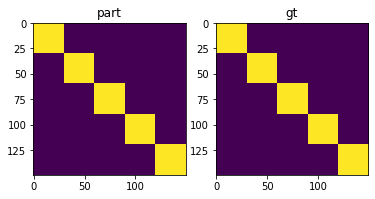

In [11]:
part_adj = part2adj(part)
plt.subplot(1,2,1), plt.imshow(part_adj), plt.title('part')
gt_adj = part2adj(gt)
plt.subplot(1,2,2), plt.imshow(gt_adj), plt.title('gt')

So we can see those two representations are identical. If we were to count the proportion of elements in the two matrices that are identical (excluding the diagonal which is always 1), we would get a measure of agreement called the Rand index. And here Rand would be 1, because all coefficients are the same (and the two cluster solutions are thus identical). But even if we selected 5 clusters randomly with equal size, we would get a Rand that is substantially higher than 0, because we would have lots of blue coefficients in our adjacency matrices, and those would necessarily overlap. The **adjusted Rand** score corrects for this chance-level overlap, such that the adjusted Rand will be close to zero for cluster overlap near chance level, and adjusted Rand is 1 for identical cluster solutions. Let's apply this measure here:

In [12]:
perf = metrics.adjusted_rand_score(part,gt[:,0])
print("adjusted rand score:",perf)

adjusted rand score: 1.0


Note that scikit-learn actually does not need the adjacency matrix representation, but works directly from vectors of cluster labels. Now that we are familiar with the adjusted Rand index, let's run another simulation with less homogeneity whithin clusters (`alpha=0.3`), to see if k-means fairs as well as before. 

In [13]:
y, gt = simu_tseries(n_time=100, n_roi=150, n_clusters=5, alpha=0.3)
cent, part, inert  = cluster.k_means(y, n_clusters=5, init="random", max_iter=30)

Let's visualize again the adjacency matrices and compute the performance of k-means:

adjusted rand score: 0.2007335728314177


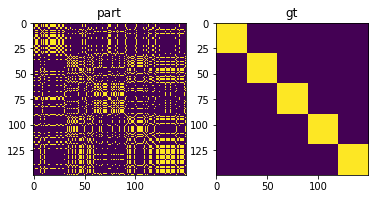

In [14]:
part_adj = part2adj(part)
plt.subplot(1,2,1), plt.imshow(part_adj), plt.title('part')
gt_adj = part2adj(gt)
plt.subplot(1,2,2), plt.imshow(gt_adj), plt.title('gt')
perf = metrics.adjusted_rand_score(part,gt[:,0])
print("adjusted rand score:",perf)

So we have definitely found a scenario where k-means struggles. But this is just one simulation. Let's repeat the experiment a bunch of times and see how the performance replicates.

Mean performance (adjusted Rand):  0.32399959427730257


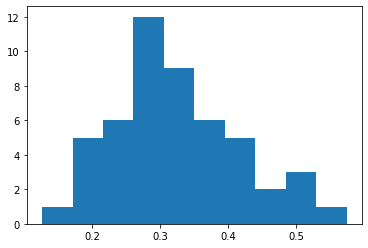

In [15]:
n_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y, gt = simu_tseries(n_time=100, n_roi=150, n_clusters=5, alpha=0.3)
    cent, part, inert  = cluster.k_means(y, n_clusters=5, init="random", max_iter=30)
    perf[ss] = metrics.adjusted_rand_score(part, gt[:,0])
plt.hist(perf)
print("Mean performance (adjusted Rand): ",perf.mean())

So let's see now if we can improve the performance of k-means through bootstrap aggregation (bagging).

## Bagging
We are now going to try out the evidence accumulation algorithm described by [Fred and Jain (2005)](https://www.ncbi.nlm.nih.gov/pubmed/15943417). The algorithm, outlined in the figure below, is as follows:
 * replicate the original time series multiple times, using bootstrap. 
 * for each replicated time series, replicate k-means. 
 * Represent each cluster solution as an adjacency matrix, and average them. This generates a "stability" or "co-occurence" matrix. 
 * Feed the stability matrix into a clustering procedure as a feature matrix. This cluster solution is an aggregate of all replications, and maybe it works better, because averaging is magic.

We are going to break down this relatively complex procedure into a series of simple code, starting with bootstrapping time series.
<img src="fig_basc_fmri.png">

In [16]:
def bootstrap_tseries(tseries):
    """ Bootstrap time series over multiple regions
    """
    ind = np.floor(tseries.shape[1] * np.random.rand(tseries.shape[1]))
    tseries_r = np.array([tseries[ii, ind.astype('int')] for ii in range(0, tseries.shape[0])])
    return tseries_r

Let's unpack this quickly. In the first line we are selecting random time points, **with replacement**. This means we sample integers between `0` and `n_time`, and that a given integer can be selected multiple times. This is the simplest form of the bootstrap, and there are better variants for time series, but we'll stick with that for this tutorial. On line 2, the same random time samples, are extracted for each region and pasted into a replication array. Let's try it out on simple time series.

In [17]:
tseries = np.array([[ii for ii in range(0,10)], [ii for ii in range(10,20)]])
tseries_r = bootstrap_tseries(tseries)
print("Original time series:\n",tseries, "\nBootstrap replication:\n", tseries_r)

Original time series:
 [[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]] 
Bootstrap replication:
 [[ 7  9  3  3  1  0  0  6  7  7]
 [17 19 13 13 11 10 10 16 17 17]]


As we can see, the two set of time series have the exact same size. Some time points are present multiple times (and not necessarily adjacent to one another), but the exact same time samples are picked for each region, so to respect spatial correlations present in the data. 

We are now ready to build a function that does the replication, apply k-means, and average the resulting adjancency matrix to give us a stability matrix.

In [18]:
def tseries2stab(tseries, n_clusters, n_samp=30, init="random", max_iter=30):
    """Estimate a cluster stability matrix from multiple time series
    """
    for ss in range(0,n_samp):
        tseries_r = bootstrap_tseries(tseries)
        cent, part, inert  = cluster.k_means(tseries_r, n_clusters=n_clusters, init=init, max_iter=max_iter)
        stab = part2adj(part) if (ss==0) else part2adj(part) + stab
    stab = stab / n_samp
    return stab

That's really the core of the bagging. Let's run a quick simulation, and compare the spatial correlation matrix with the stability matrix.

(<matplotlib.axes._subplots.AxesSubplot at 0x7f62fcb41908>,
 Text(0.5, 1.0, 'stability'))

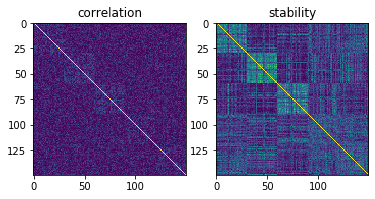

In [19]:
y, gt = simu_tseries(n_time=100, n_roi=150, n_clusters=5, alpha=0.3)
stab = tseries2stab(y, n_clusters=5)
R = corrcoef(y)

plt.subplot(1,2,1), plt.imshow(np.abs(R)), plt.title('correlation')
plt.subplot(1,2,2), plt.imshow(stab), plt.title('stability')

With the correlation matrix, which is closely related to the metric used by k-means to find clusters, it is really hard to see any structure. By contrast, the squares are relatively easy to pick with the stability matrix. So hopefully if we use that as a clustering metric, we can get better clusters!

## Consensus clustering
So here comes the last step of the BASC. We are going to apply a clustering procedure on `stab`. Let's define a small function which puts all the pieces together.

In [20]:
def basc(tseries, n_clusters, n_samp=30, init="random", max_iter=30):
    """ Bootstrap aggregation of stable clusters on time series
    """
    stab = tseries2stab(tseries, n_clusters, n_samp, init, max_iter)
    cent, cons, inert = cluster.k_means(stab, n_clusters=n_clusters, init=init, max_iter=max_iter)
    return cons

We can try it out on a simple simulation:

In [21]:
y, gt = simu_tseries(n_time=100, n_roi=150, n_clusters=5, alpha=0.3)
cons  = basc(y, n_clusters=5)

We can visualize the consensus adjacency matrix against the ground truth, and get a measure of performance:

adjusted rand score: 0.3361593409843824


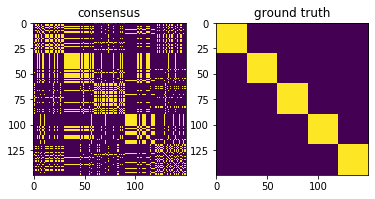

In [22]:
cons_adj = part2adj(cons)
plt.subplot(1,2,1), plt.imshow(cons_adj), plt.title('consensus')
gt_adj = part2adj(gt)
plt.subplot(1,2,2), plt.imshow(gt_adj), plt.title('ground truth')
perf = metrics.adjusted_rand_score(cons, gt[:,0])
print("adjusted rand score:", perf)

Not great, but better than what straight k-means gave us (unless you were not lucky with your random sample, which is possible). Let's run a bunch of replications of this experiment to get a better idea of the improvement.

Mean performance (adjusted Rand):  0.4760978135291099


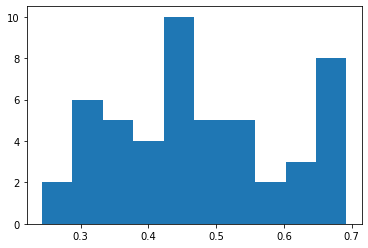

In [23]:
n_simu = 50
perf = np.zeros(n_simu)
for ss in range(0,n_simu) :
    y, gt = simu_tseries(n_time=100, n_roi=150, n_clusters=5, alpha=0.3)
    cons = basc(y, n_clusters=5)
    perf[ss] = metrics.adjusted_rand_score(cons, gt[:,0])
plt.hist(perf)
print("Mean performance (adjusted Rand): ",perf.mean())

An improvement of 0.15+ in adjusted Rand index, not too shabby! Now we could get this type of results by using a more complex algorithm, such as k-means++ initialization. But we could BASC the kmeans++, and still get improvements. We can even mix different algorithms in the bagging, and get some hybrid algorithm. That's actually what Fred and Jain originally proposed, the consensus clustering idea was already present in [Monti et al. (2003)](https://link.springer.com/article/10.1023/A:1023949509487) and possibly earlier works as well. 

# Real data

## Preparing data
Now it is time for the real thing, enough of the toy simulations. Let's just fetch some individual fMRI data with nilearn.

In [24]:
abide_dataset = datasets.fetch_abide_pcp(n_subjects=1)
epi_filename = abide_dataset.func_preproc[0]

/home/pbellec/env/jupyter_ds/lib/python3.7/site-packages/numpy/lib/npyio.py:2358: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


If we work directly with voxels, the stability matrix will be huge. And BASC will be very slow. We are going to work on small regions instead. Let's grab a pre-computed parcellation for that. There are ways to generate efficiently these "super-voxels" in a data-driven fashion, but that's beyond the scope of this tutorial.

In [25]:
# load atlas
multiscale = datasets.fetch_atlas_basc_multiscale_2015()
atlas_filename = multiscale.scale444

# initialize masker (change verbosity)
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True, verbose=0)

We are going to convert the 4D fMRI data into a time series array `n_roi` x `n_time` 

In [26]:
masker.fit(epi_filename)
y = masker.transform(epi_filename)
y = y.transpose()
y.shape

(444, 196)

## Hierarchical clustering and re-ordering
In the simulation, we could see the clustering structure, because it was built to have square on the diagonal. But for the real data, we don't know how to order the regions by cluster. Unless we use an agglomerative hierarchical clustering. Hierarchical clustering is, with k-means, one of the oldest and most standard algorithm. It proceeds by iteratively merging the most similar clusters, starting from each cluster being a region. In this merging process, the regions get sorted based on their cluster structure, and this can be used to visualize the cluster structure. You can check out this [tutorial](https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/) to learn more about the algorithm, but we are going to use it as a black box here:

In [27]:
hier = linkage(y, method='ward', metric='euclidean') # scipy's hierarchical clustering
res = dendrogram(hier, get_leaves=True, no_plot=True) # Generate a dendrogram from the hierarchy
order = res.get('leaves') # Extract the order on papers from the dendrogram

Let's cut the hierachy to get a parcellation into seven clusters, and visualize both the correlation matrix as well as the adjacency matrix:

/home/pbellec/env/jupyter_ds/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/pbellec/env/jupyter_ds/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


Text(0.5, 1.0, 'partition')

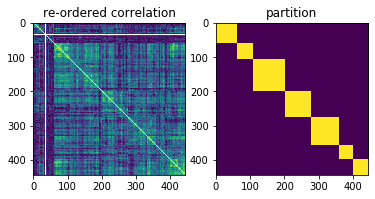

In [28]:
part = np.squeeze(cut_tree(hier, n_clusters=7)) # Cut the hierarchy 
R = corrcoef(y)
R_order = np.array([R[ii,order] for ii in order])
adj = part2adj(part)
adj_order = np.array([adj[ii,order] for ii in order])

plt.subplot(1,2,1)
plt.imshow(np.abs(R_order))
plt.title('re-ordered correlation')

plt.subplot(1,2,2)
plt.imshow(adj_order)
plt.title('partition')

It's hard to see the structure of the seven networks. We can also notice a region without signal (white row/column, probably outside the mask), and a first highly heterogeneous cluster. Let's estimate the stability matrix, and use stability as features for the hierarchical clustering.

In [29]:
stab = tseries2stab(y, n_clusters=7)
hier = linkage(stab, method='ward', metric='euclidean') # scipy's hierarchical clustering
res = dendrogram(hier, get_leaves=True, no_plot=True) # Generate a dendrogram from the hierarchy
order = res.get('leaves') # Extract the order on papers from the dendrogram
part = np.squeeze(cut_tree(hier, n_clusters=7)) # Cut the hierarchy 
adj = part2adj(part)
adj_order = np.array([adj[ii,order] for ii in order])
stab_order = np.array([stab[ii,order] for ii in order])

We can visualize the stability matrix and the partition side by side:

Text(0.5, 1.0, 'partition')

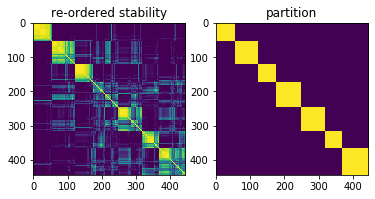

In [30]:
plt.subplot(1,2,1)
plt.imshow(np.abs(stab_order))
plt.title('re-ordered stability')

plt.subplot(1,2,2)
plt.imshow(adj_order)
plt.title('partition')

The cluster structure is much cleaner, and many clusters seem to have high stability. We can transform back this partition on the brain.

In [31]:
img_part = masker.inverse_transform( np.reshape(part+1,[1,part.shape[0]]) )
plotting.view_img( img_part, resampling_interpolation='nearest')

Some classical networks are nicely identified, like the sensorimotor. The cerebellum get segmented out. But we can also average the stability matrix inside a consensus cluster to get a feel of which region got consistently associated with this cluster. Let's look at one of the clusters:

In [32]:
stab_map = np.mean(stab[:,part==0], axis=1)
img_stab_map = masker.inverse_transform( np.reshape(stab_map,[1,stab_map.shape[0]]) )
plotting.view_img( img_stab_map)

And that's it! I hope you learned a few things on classical clustering techniques, and bootstrap aggregation. It's a simple, yet powerful approach to stabilize your cluster analysis. To get more empirical results showing the benefits for functional brain parcellation, you can check this [recent preprint](https://www.biorxiv.org/content/10.1101/343392v2). Note that there is a python package currently in development for BASC in python, that adds lots of important implementation details to the general ideas we covered here. The package is called pybasc, and you can find it on [github](https://github.com/AkiNikolaidis/PyBASC).